In [77]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
import cmath

%matplotlib widget
import matplotlib.pyplot as plt

In [78]:
time_gating = True # указать, нужен или не нужен

No such comm: c27d8e2abc01445ebb8b92f73ad03689
No such comm: c27d8e2abc01445ebb8b92f73ad03689


### Импорт сырых данных из .s2p файла и перевод их в комплексные числа

In [79]:
data_object_off = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\29sept\\TE\\struct_15deg_inverse5V.s1p', 
                sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS12', 'ImS12'])

data_object_on = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\29sept\\TE\\struct_15deg_6A.s1p', 
                sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS12', 'ImS12'])

data_screen = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\29sept\\TE\\screen_15deg.s1p', 
                sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS12', 'ImS12'])

data_free = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\29sept\\TE\\free_15deg.s1p', 
        sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS12', 'ImS12'])

No such comm: 1164cf648d594a7ca66aaa55ce4ccd60


In [80]:
data_object_on.head() # Смотрим корректность импорта данных

,Frequency,ReS12,ImS12
0,2.000000e+10,0.051857,0.089153
1,2.000200e+10,0.065790,0.080101
2,2.000400e+10,0.078672,0.067855
3,2.000600e+10,0.089369,0.053282
4,2.000800e+10,0.097264,0.037255


Перевод данных в вид комплексных чисел

In [81]:
for dataset in [data_object_off, data_object_on, data_screen, data_free]: # это массив из указателей на соответствующие
    dataset['s12']=dataset['ReS12']+1j*dataset['ImS12']

Удаление исходных колонок

In [82]:
data_object_off = data_object_off.drop(['ReS12', 'ImS12'], axis=1)
data_object_on = data_object_on.drop(['ReS12', 'ImS12'], axis=1)
data_screen = data_screen.drop(['ReS12', 'ImS12'], axis=1)
data_free = data_free.drop(['ReS12', 'ImS12'], axis=1)

In [83]:
data_object_on.head() # просмотр нового датасета

,Frequency,s12
0,2.000000e+10,0.051857+0.089153j
1,2.000200e+10,0.065790+0.080101j
2,2.000400e+10,0.078672+0.067855j
3,2.000600e+10,0.089369+0.053282j
4,2.000800e+10,0.097264+0.037255j


Создаем переменные, с которыми будем непосредственно работать (массивы формата `pd.Series`)

In [84]:
frequency = data_object_off['Frequency']

s21_object_off = data_object_off['s12']

s21_object_on = data_object_on['s12']

s21_screen = data_screen['s12']

s21_free = data_free['s12']

### Предпросмотр графиков необработанных файлов

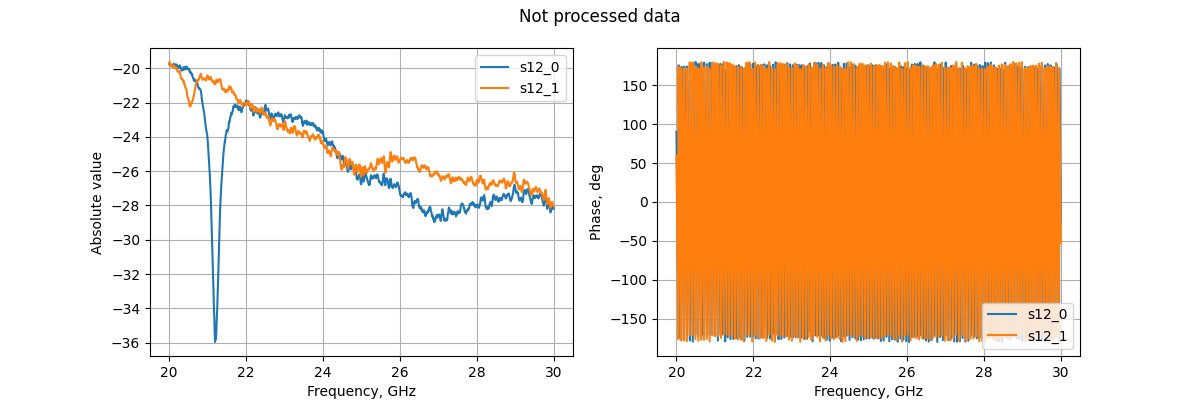

In [85]:
s_par = ['s12'] # Вести сюда названия S-параметров, которые нужны на графике в формате 'sij'
data = [data_object_off, data_object_on] # Ввести сюда какие измерения нужны


'''Дальше  не трогать!!!'''
fig = plt.figure(figsize=(12,4))

ax_1 = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)
for i, dataset in enumerate(data):
    for elem in s_par:
        ax_1.plot(dataset['Frequency']*1e-9, 20*np.log10(dataset[elem].apply(abs).to_numpy()), label=elem+'_'+str(i))
        ax_2.plot(dataset['Frequency']*1e-9, np.degrees(dataset[elem].apply(cmath.phase)), label=elem+'_'+str(i))

ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()

ax_2.set_xlabel("Frequency, GHz")
ax_2.set_ylabel("Phase, deg")
ax_2.legend()
ax_2.grid()


fig.suptitle('Not processed data')
#plt.tight_layout()
plt.show()

### Time-Gating

In [86]:
N_fft = 2 ** 22 # количиство точек во временной области
# Должно иметь степень двойки для большей скорости и быть большем, чем количество частотных точек
T_max = 1 / (frequency[1]-frequency[0]) # продолжительность измеряемого импульса, определяется из количества измеряемых частотных точек
print(T_max)

5e-07


In [87]:
time = T_max*np.linspace(0, 1, N_fft) # набор точек во временной области
time[-1] # последний элемент

5e-07

Просмотр S-параметров во временной области

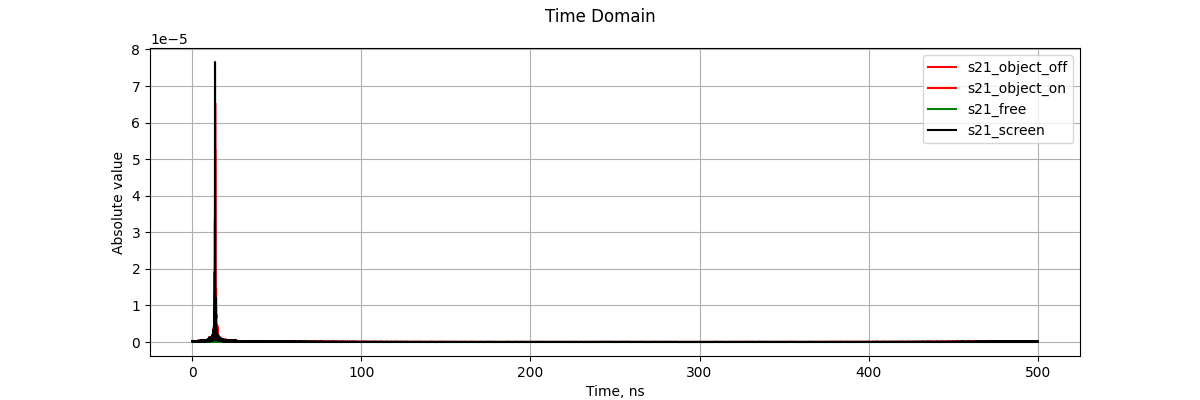

In [88]:
fig2 = plt.figure(figsize=(12,4))

ax_1 = fig2.add_subplot(111)
ax_1.plot(time*1e9, abs(ifft(s21_object_off.to_numpy(), n=N_fft)),'r', label='s21_object_off')
ax_1.plot(time*1e9, abs(ifft(s21_object_on.to_numpy(), n=N_fft)),'r', label='s21_object_on')
ax_1.plot(time*1e9, abs(ifft(s21_free.to_numpy(), n=N_fft)),'g', label='s21_free')
ax_1.plot(time*1e9, abs(ifft(s21_screen.to_numpy(), n=N_fft)),'k', label='s21_screen')

ax_1.set_xlabel("Time, ns")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()


fig2.suptitle('Time Domain')
plt.show()

In [89]:
gate_s21 = np.array([[0, 10], [17, 900]])*1e-9 # заполнить промежутками времени, которые необходимо вырезать в нс

In [90]:
def time_gate_s_param(gate: np.ndarray, s_par: pd.core.series.Series, n=N_fft, time=time):
    s = s_par.to_numpy()
    time_dom_s = pd.Series(ifft(s, n=n))
    for k in range(gate.shape[0]):
        if len(gate[k, :]) != 0:
            numbers = (time >= gate[k, 0]) & (time <= gate[k, 1])
            time_dom_s.loc[numbers] = 0
            #print(time_dom_s.head())
    s_new = fft(time_dom_s.to_numpy())
    s_new = s_new[0:len(frequency)]
    return pd.Series(s_new)

Проведение тайм-гейтинга

In [91]:
if time_gating == True:
    s21_object_off = time_gate_s_param(gate=gate_s21, s_par=s21_object_off)
    s21_object_on = time_gate_s_param(gate=gate_s21, s_par=s21_object_on)
    s21_screen = time_gate_s_param(gate=gate_s21, s_par=s21_screen)
    s21_free = time_gate_s_param(gate=gate_s21, s_par=s21_free)

In [92]:
s21_object_on.shape # проверка, что число точек осталось таким же, как в исходных данных

(5001,)

Просмотр S-параметров после тайм-гейтинга

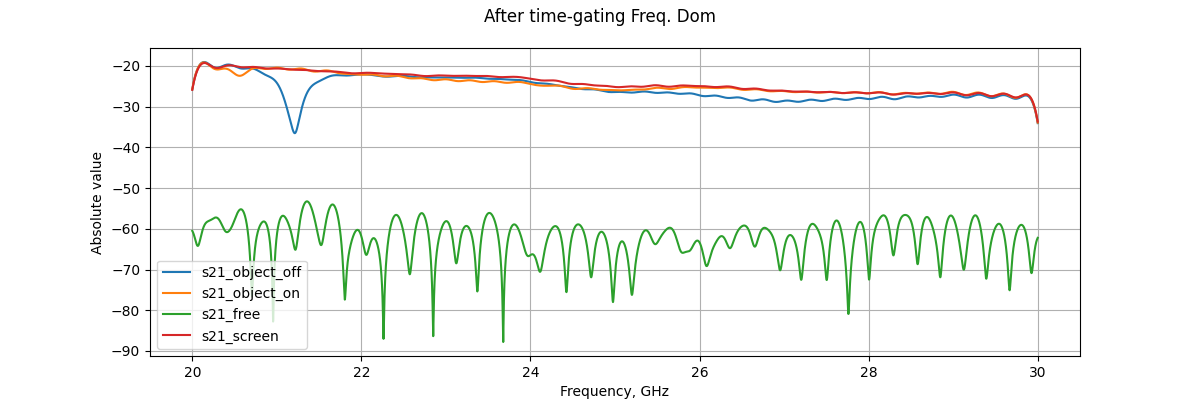

In [93]:
param = [s21_object_off, s21_object_on, s21_free, s21_screen]
name = ['s21_object_off', 's21_object_on', 's21_free', 's21_screen']

fig3 = plt.figure(figsize=(12,4))

ax_1 = fig3.add_subplot(111)

for i, s_par in enumerate(param):
    ax_1.plot(frequency*1e-9, 20*np.log10(s_par.apply(abs).to_numpy()), label=name[i])
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()


fig3.suptitle('After time-gating Freq. Dom')
plt.show()

### Итоговые выражения для коэффициента отражения

In [94]:
Gamma_off = -(s21_object_off - s21_free) / (s21_screen - s21_free)
Gamma_on = -(s21_object_on - s21_free) / (s21_screen - s21_free)

### Импорт графиков из CST

In [95]:
reflecting_coef_off = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\off_cst\\15deg.txt',
                                  sep='\t', header=None, skiprows=3, index_col=False, names=['Frequency', 'ReSz11', 'ImSz11'])
reflecting_coef_on = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\on_cst\\15deg.txt',
                                  sep='\t', header=None, skiprows=3, index_col=False, names=['Frequency', 'ReSz11', 'ImSz11'])

In [96]:
reflecting_coef_off['Sz11'] = reflecting_coef_off['ReSz11'] + 1j*reflecting_coef_off['ImSz11']
reflecting_coef_on['Sz11'] = reflecting_coef_on['ReSz11'] + 1j*reflecting_coef_on['ImSz11']

In [97]:
reflecting_coef_off = reflecting_coef_off.drop(['ReSz11', 'ImSz11'], axis=1)
reflecting_coef_on = reflecting_coef_on.drop(['ReSz11', 'ImSz11'], axis=1)

### Сравенние графиков с результатами CST

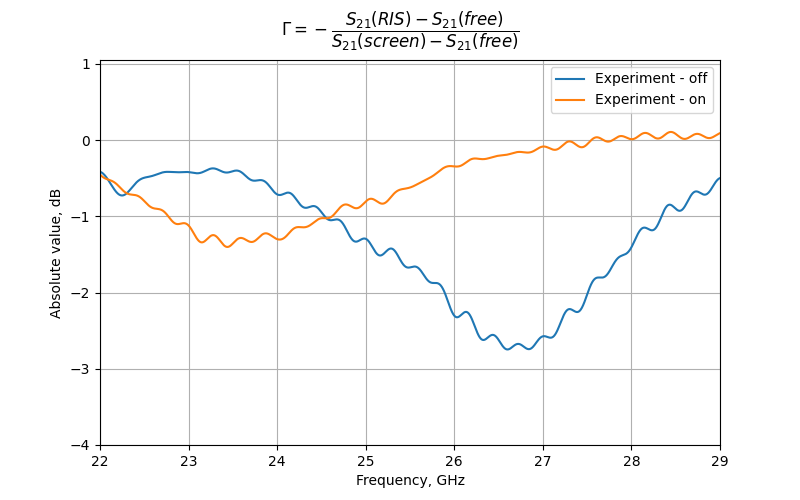

In [98]:
fig4 = plt.figure(figsize=(8, 5))

ax_1 = fig4.add_subplot(111)

ax_1.plot(frequency*1e-9, 20*np.log10(Gamma_off.apply(abs).to_numpy()), label='Experiment - off')
ax_1.plot(frequency*1e-9, 20*np.log10(Gamma_on.apply(abs).to_numpy()), label='Experiment - on')
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Absolute value, dB")
ax_1.set_xlim(left=22, right=29)
ax_1.set_ylim(bottom=-4)
ax_1.legend()
ax_1.grid()


fig4.suptitle(r'$\Gamma = -\dfrac{S_{21}(RIS)-S_{21}(free)}{S_{21}(screen)-S_{21}(free)}$')
plt.show()

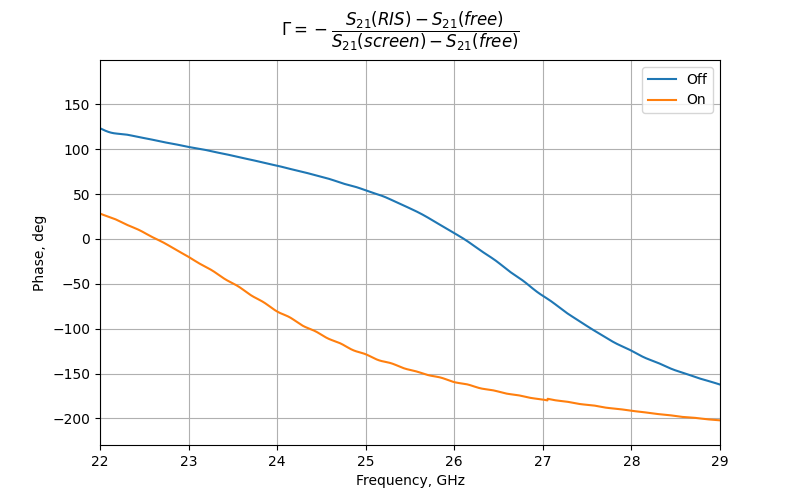

In [99]:
fig4 = plt.figure(figsize=(8, 5))

ax_1 = fig4.add_subplot(111)

ax_1.plot(frequency*1e-9, np.degrees(pd.Series(Gamma_off).apply(cmath.phase).to_numpy()), label='Off')
ax_1.plot(frequency*1e-9, np.unwrap(np.degrees(pd.Series(Gamma_on).apply(cmath.phase).to_numpy())), label='On')
#ax_1.scatter([25], [-180], color='r', label = r'25 GHz, $\Delta\phi = 180$')
#ax_1.plot(cst_freq, np.degrees(cst_Gamma.apply(cmath.phase).to_numpy()), label='Modeling')
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Phase, deg")
ax_1.set_xlim(left=22, right=29)
ax_1.legend()
ax_1.grid()


fig4.suptitle(r'$\Gamma = -\dfrac{S_{21}(RIS)-S_{21}(free)}{S_{21}(screen)-S_{21}(free)}$')
plt.show()

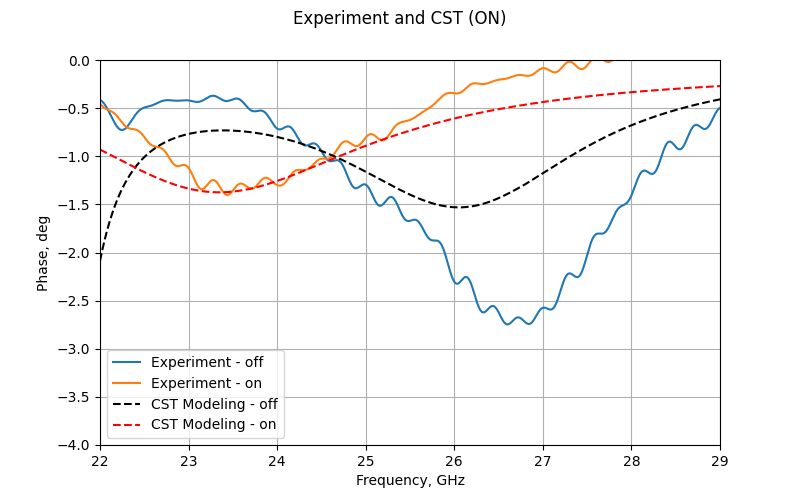

In [103]:
fig7 = plt.figure(figsize=(8,5))

ax_1 = fig7.add_subplot(111)

ax_1.plot(frequency*1e-9, 20*np.log10(Gamma_off.apply(abs).to_numpy()), label='Experiment - off')
ax_1.plot(frequency*1e-9, 20*np.log10(Gamma_on.apply(abs).to_numpy()), label='Experiment - on')
ax_1.plot(reflecting_coef_off['Frequency'], 20*np.log10(reflecting_coef_off['Sz11'].apply(abs).to_numpy()), linestyle='--', color='k', label='CST Modeling - off')
ax_1.plot(reflecting_coef_on['Frequency'], 20*np.log10(reflecting_coef_on['Sz11'].apply(abs).to_numpy()), linestyle='--', color='r', label='CST Modeling - on')

ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Phase, deg")
ax_1.set_xlim(left=22, right=29)
ax_1.set_ylim(top=0, bottom=-4)
ax_1.legend()
ax_1.grid()


fig7.suptitle('Experiment and CST (ON)')
plt.show()

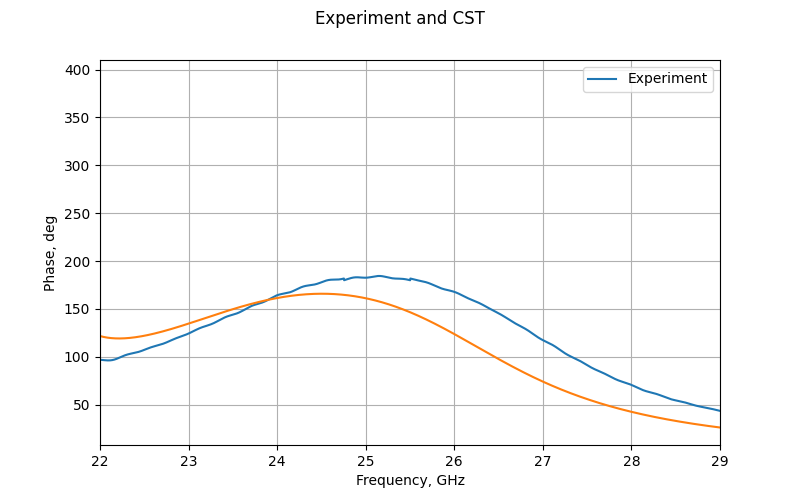

In [107]:
fig5 = plt.figure(figsize=(8,5))

ax_1 = fig5.add_subplot(111)

ax_1.plot(frequency*1e-9, 360+np.unwrap(np.degrees(pd.Series(Gamma_off / Gamma_on).apply(cmath.phase).to_numpy())), label='Experiment')
ax_1.plot(reflecting_coef_off['Frequency'], np.degrees(pd.Series(reflecting_coef_off['Sz11'] / reflecting_coef_on['Sz11']).apply(cmath.phase).to_numpy()))

ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Phase, deg")
ax_1.set_xlim(left=22, right=29)
#ax_1.set_ylim(top=190, bottom=140)
ax_1.legend()
ax_1.grid()


fig5.suptitle('Experiment and CST')
plt.show()

In [100]:
delta_phi = pd.DataFrame({'Frequency':frequency, 'G_off/G_on':Gamma_off/Gamma_on})
delta_phi.head()

,Frequency,G_off/G_on
0,2.000000e+10,0.854516+0.508177j
1,2.000200e+10,0.854599+0.508587j
2,2.000400e+10,0.854685+0.508985j
3,2.000600e+10,0.854772+0.509371j
4,2.000800e+10,0.854862+0.509745j


In [101]:
#delta_phi.to_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\phase_diff\\15deg_TE.csv' ,index=False)